In [5]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import glob
from collections import defaultdict
import cv2
import numpy as np

In [6]:
!git clone https://github.com/facebookresearch/detr.git # get loss function
!pip install lightning
!pip install torchmetrics
!pip install huggingface_hub

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 265 (delta 0), reused 1 (delta 0), pack-reused 264
Receiving objects: 100% (265/265), 12.88 MiB | 29.97 MiB/s, done.
Resolving deltas: 100% (123/123), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 942.1 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.2 MB/s eta 0:00:0000:0100:01


## Prepare data

In [7]:
train_label = '/kaggle/input/vietnamese-license-plate/LP_detection/labels/train'
val_label = '/kaggle/input/vietnamese-license-plate/LP_detection/labels/val'
import sys
sys.path.append('./detr/')

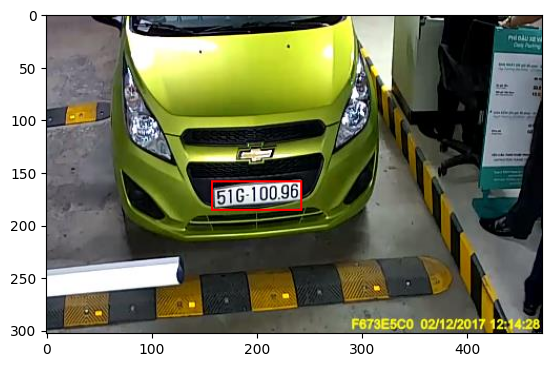

In [8]:
def visualize(label_url = '/kaggle/input/vietnamese-license-plate/LP_detection/labels/train/CarLongPlate0.txt'):
    img_url = label_url.replace('labels','images').replace(".txt",'.jpg')
    img = Image.open(img_url).convert("RGB")
    draw = ImageDraw.Draw(img)
    width, height = img.size
    with open(label_url,'r') as f:
        for line in f.readlines():
            label,x,y,w,h = [float(i.replace('\n','')) for i in line.split(" ")]
            x1 = x - w/2
            x2 = x + w/2
            y1 = y - h/2
            y2 = y + h/2
            x1,x2 = int(x1*width),int(x2*width)
            y1,y2 = int(y1*height),int(y2*height)
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
    plt.imshow(img)
visualize()

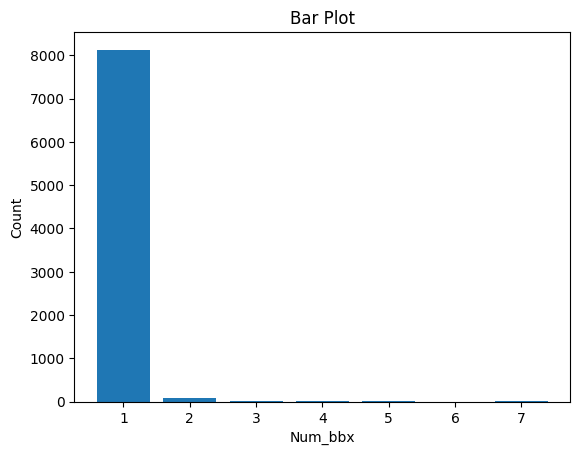

In [9]:
# check number of bb per image
count = defaultdict(lambda:0)
for dataset_url in [train_label,val_label]:
    urls = glob.glob(dataset_url+'/*')
    for url in urls:
        with open(url,'r') as f:
            data = f.readlines()
        count[len(data)] +=1
    
    

plt.bar(count.keys(), count.values())
plt.xlabel('Num_bbx')
plt.ylabel('Count')
plt.title('Bar Plot')
plt.show()
# use about 20 queries

In [10]:
# Build transform
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      
                      A.Resize(height=512, width=512, p=1),
                      
                     
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='yolo',min_area=0, min_visibility=0,label_fields=['labels'])
                      )
def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='yolo',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## Build dataset

In [11]:
class LicensePlateDataset(Dataset):
    def __init__(self,labels,transforms=None):
        self.labels = glob.glob(labels+'/*')
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return len(self.labels)
    
    def __getitem__(self,index):
        label_url = self.labels[index]
        img_url = label_url.replace('labels','images').replace(".txt",'.jpg')
        
        image = cv2.imread(img_url, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        bboxes = []
        labels = []
        height,width,_ = image.shape
        
        # DETR takes in data in coco format 
        with open(label_url,'r') as f:
            for line in f.readlines():
                label,x,y,w,h = [float(i.replace('\n','')) for i in line.split(" ")]
                labels.append(label)
                bboxes.append([x,y,w,h])
        labels = np.array(labels,dtype = np.int32)
        bboxes = np.array(bboxes)
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': bboxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
        
        
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)

        
        return image, target

## build model

In [12]:
from huggingface_hub import PyTorchModelHubMixin
class DETRModel(nn.Module,PyTorchModelHubMixin):
    def __init__(self,num_classes = 2,num_queries = 20):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

## build module

In [13]:
import lightning.pytorch as L
from torchmetrics.functional import accuracy, f1_score
from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

class DETR_Module(L.LightningModule):
    def __init__(self,train_label,val_label,num_classes,num_queries,lr,weight_decay,max_epochs,collate_fn,**kwargs):
        self.save_hyperparameters()
        super().__init__()
    
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.model = DETRModel( num_classes,num_queries) 
        self.collate_fn = collate_fn
        self.train_label = train_label
        self.val_label = val_label
        weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
        losses = ['labels', 'boxes', 'cardinality']
        matcher = HungarianMatcher()
        self.criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = 0.5, losses=losses)
        
    def setup(self, stage: str):
        if stage == "fit":
            self.train_dataset = LicensePlateDataset(
                    self.train_label,
                    transforms=get_train_transforms()
                    )
            self.val_dataset = LicensePlateDataset(
                    self.val_label,
                    transforms=get_valid_transforms()
                    )
      
    def forward(self,images):
        images = list(images)
        return self.model(images)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        targets = list(targets)
        
        output = self(images)
        loss_dict = self.criterion(output, targets)
        weight_dict = self.criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
       
        # Logging to TensorBoard by default
        self.log("train_loss", losses, prog_bar=True,on_step=True, on_epoch=True)

        return losses

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        targets = list(targets)
        
        output = self(images)
        loss_dict = self.criterion(output, targets)
        weight_dict = self.criterion.weight_dict
       
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

    
        # Logging to TensorBoard by default
        self.log("val_loss", losses, prog_bar=True,on_step=False, on_epoch=True)
        
        return losses


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        if self.max_epochs is not None:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer=optimizer,step_size = 5, gamma=0.5
            )
            return [optimizer], [lr_scheduler]
        else:
            return optimizer
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32,shuffle = True,collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32,collate_fn=self.collate_fn)


        

In [14]:
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from  lightning.pytorch.callbacks import ModelCheckpoint

lr = 1e-4
weight_decay = 0
max_epochs = 20
n_classes = 2 # Positive or Negative

trainer = L.Trainer(
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min",min_delta=0.00, patience=15,check_finite = True ),
        ModelCheckpoint(dirpath="/kaggle/working/", save_top_k=1, monitor="val_loss",save_last = True)
              ],
    max_epochs=max_epochs,
    accelerator="auto", devices='auto',

    log_every_n_steps = 1,
)
def collate_fn(batch):
    return tuple(zip(*batch))
num_classes = 2 # license plate and no object
num_queries = 20
model = DETR_Module(train_label,val_label,num_classes,num_queries,lr,weight_decay,max_epochs,collate_fn)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The curr

In [15]:
trainer.fit(model)

2024-05-08 15:01:16.532321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 15:01:16.532454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 15:01:16.620586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | DETRM

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
model = DETR_Module.load_from_checkpoint("/kaggle/working/epoch=18-step=3933.ckpt")

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# save locally
model.model.save_pretrained("vietnamese_license_plate_detection_DeRT")

# push to the hub
model.model.push_to_hub("vietnamese_license_plate_detection_DeRT")

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NCTuanAnh/vietnamese_license_plate_detection_DeRT/commit/c9b98d05cf963c318099887345550ab21550a0ed', commit_message='Push model using huggingface_hub.', commit_description='', oid='c9b98d05cf963c318099887345550ab21550a0ed', pr_url=None, pr_revision=None, pr_num=None)

In [19]:
import requests
class LicensePlateInference():
    def __init__(self):
       
        self.transforms = A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      )
        
        
 
    def __call__(self,img_url): 
        image = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
        image = np.array(image,dtype = np.float32)
        image /= 255.0
      
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image'].unsqueeze(dim = 0)
           
        
        return image

In [20]:
model = DETRModel.from_pretrained("NCTuanAnh/vietnamese_license_plate_detection_DeRT")
model.eval()
print()

config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

0.21918614 0.6363793 0.18311319 0.10180289


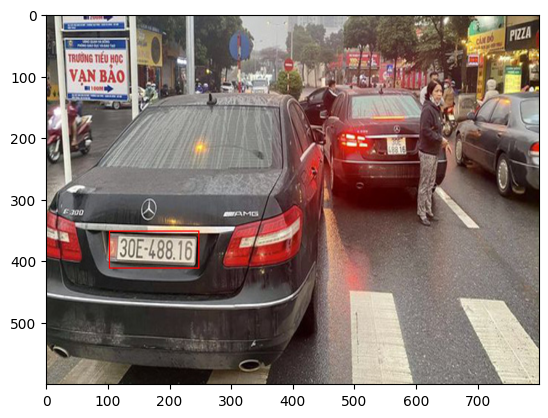

In [21]:
url = 'https://static.tuoitrenews.vn/ttnew/r/2021/03/03/img7954ucnz-16146639296152140911427-1614752407.jpg'
data = LicensePlateInference()
img = data(url)
output = model(img)
out = (output['pred_logits'].argmax(dim = -1) == 0).bool()
bboxes = output['pred_boxes'][out].detach().cpu().numpy()

img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
draw = ImageDraw.Draw(img)
width, height = img.size
for x,y,w,h in bboxes:
    print(x,y,w,h)
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    x1,x2 = int(x1*width),int(x2*width)
    y1,y2 = int(y1*height),int(y2*height)
    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
plt.imshow(img)
plt.show()